# Convolutional Neural Network

Practical exampl for the programming of a convolutional neural network for image classification

## Library import

We load the necessary libraries.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score

## Load the Dataset

We load file 'dataset.npz', which contains the MNIST images that we will use.

In [ ]:
import urllib.request
import zipfile
url = "https://github.com/wobc/cmb_website/raw/main/materials/2025/DNN/code/dataset.npz.zip"
urllib.request.urlretrieve(url, "dataset.npz.zip")

# Extract the zip file
with zipfile.ZipFile("dataset.npz.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
dataset = np.load('dataset.npz')
data = dataset['data']
labels = dataset['labels']

We visualize a few sample images to understand their format and structure.

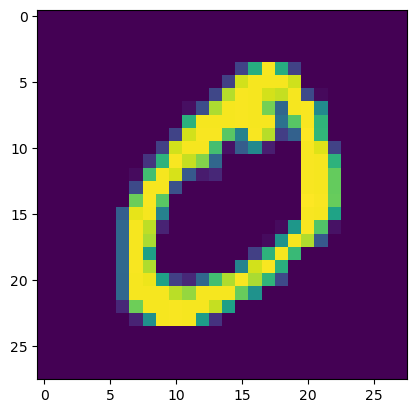

In [9]:
# Imagen 1
plt.imshow(data[1,:])

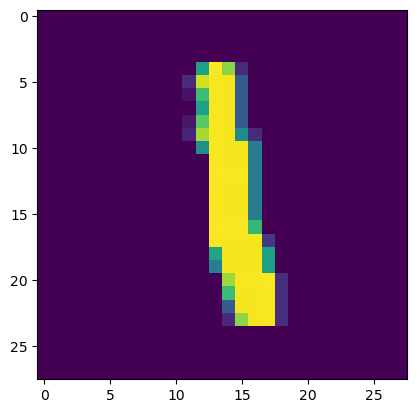

In [10]:
# Imagen 2
plt.imshow(data[6,:])

## Experimentos Setup

It is essential to plan all the key components of a deep learning experiment in advance to understand what will be needed:
- Data loading
- Hyperparameter specification
- Model creation
- Results analysis

It is important that the data used to train the model is different from the data used to evaluate its performance.
To achieve this, we split the data (and corresponding labels) into training (90%) and testing (10%).

In [11]:
# Train/test
data_tr = data[0:int(data.shape[0]*0.9),:]
data_te = data[int(data.shape[0]*0.9):,:]

labels = labels.astype('float32')

labels_tr = labels[0:int(data.shape[0]*0.9)]
labels_te = labels[int(data.shape[0]*0.9):labels.shape[0]]

We use the Dataset class included in the PyTorch library to prepare the data for loading into the neural network.

In [12]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data,labels):
        'Initialization'
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.list_IDs=np.arange(data.shape[0])
        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        
        #X = self.stack[ID,:].astype(np.float32) 
        X = self.data[ID,:] # I think it's not necessary because it's already converted to float32.
        
        X=np.expand_dims(X,0) # Expands the dimensions (we go from 3 to 4).
        # Convolutional networks expect a 4D tensor: (batch_size, channels, height, width).
        # If we have a 2D image, we need to add dimensions for:
        # - Batch (first dimension)
        # - Channels (second dimension)

        X=torch.from_numpy(X)
        
        y = self.labels[ID]
        
        return X,y # Returns both the image and the label.

We create the training and test sets from the Dataset class.

In [13]:
training_set=Dataset(data_tr,labels_tr)
testing_set=Dataset(data_te,labels_te)

Sometimes, the dataset is so large that it’s not possible to feed all the data into the neural network at once.
This is especially common when using a GPU instead of a CPU for training—which is generally recommended when available.

To handle this, we define a batch size, meaning only a subset of the data is passed to the network at a time.
For example, batch_size = 8 means only 8 images are processed at once. All gradient-based computations, backpropagation, and resulting metrics are calculated only for those 8 images.

What batch size should we choose?
- For the training set: the largest size that doesn’t exceed your system’s memory.
- For the test set: 1 — since once the network is trained, we want to evaluate predictions image by image.

The other parameter we define is shuffle:
- shuffle=True means the training data is randomly shuffled before each epoch. This helps prevent the model from memorizing the order of the data and improves generalization.
- For the test set, the order doesn’t matter, so we set shuffle=False.

In [14]:
params_tr = {'batch_size': 100,
                      'shuffle': True,}

params_te = {'batch_size': 1,
                      'shuffle': False}

Based on the datasets and their parameters, we create a DataLoader (also a PyTorch class) to provide the neural network with easy and efficient access to the data

In [15]:
trainloader = torch.utils.data.DataLoader(training_set, **params_tr)
testloader = torch.utils.data.DataLoader(testing_set, **params_te)

# Definition of the neural network

In [4]:
# Definition of the CNN architecture
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        # conv2d defines a convolutional layer. There are 3 main variables to adjust:
        # 1) The number of input channels. For grayscale images, it's 1 channel. 
        #    For color images (RGB), it's 3 channels.
        # 2) The number of output channels. This corresponds to the number of filters (kernels) 
        #    that will be applied. In the presentation, we saw how a single kernel works and 
        #    how the output is calculated using the dot product between the input and the kernel.
        #    In convolutional networks, we compute many such filters instead of just one.
        # 3) Kernel size: in the presentation example it was 3x3, here it's 2x2.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.max2 = nn.MaxPool2d(kernel_size=2)
    
        # Randomly sets to zero the percentage of weights specified in the input argument 
        # (in our case, 30%). This is done to prevent the model from overfitting to the 
        # training data, with the goal of improving its ability to generalize to the test data.
        self.dropout = nn.Dropout(0.3)
        
        # It is crucial to know the size of the image at the input of the first fully connected layer.
        self.fc = nn.Linear(1600, 128) 
        self.output = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # Activation function. Adds non-linearities to the model.
        x = self.max1(x)
        
        x = self.conv2(x)
        x = F.relu(x) # An activation function is added after each linear/convolutional layer.
        x = self.max2(x)
        
        # Flatten the tensor. The resulting size must match the number of input neurons
        x = self.fc(x)  # defined in this layer.
        x = self.dropout(x)
        x = self.output(x) 
                
        return x

# Training
Now that we have the model designed, we need to create a function to define how the training will be carried out. 
In this function, we specify all the details and settings for how we want the training process to run.

In [5]:
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    # Function to train our neural network.
    # When working with heavy data, such as 3D images (e.g., fMRI), it's highly recommended 
    # to run the training process on a GPU instead of the computer's CPU.
    # In fact, PyTorch is designed to take advantage of the way GPUs perform computations.
    # The following line checks whether the computer has a GPU, and if so,
    # sends all the variables involved in this process to the GPU using CUDA tools.
    # If no GPU is available (or desired), everything runs on the CPU by default.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device) # Send the model to the selected device (GPU or CPU).
    
    # Although it's commonly named 'criterion', this is simply the loss function we discussed in the theory section.
    # CrossEntropyLoss() is typically used for multi-class classification problems,
    # while BCELoss() is used for binary classification problems involving only two classes.
    criterion = nn.CrossEntropyLoss() 
    # criterion = nn.BCELoss()
    
    # The optimizer is used to control the step size during gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # As we saw earlier, the input data passes through all the layers of the network until it reaches the output.
    # There, the error is calculated using the loss function. Then, backpropagation occurs,
    # adjusting the weights of all the neurons.
    # Once all of this has happened, it means one epoch has passed.
    # The training process requires repeating this weight adjustment multiple times (the exact number is unknown in advance).
    # We'll implement this using a for loop, assigning a specific number of epochs.

    for epoch in range(epochs):
        model.train() # "Notifies" the model that it is going to be trained. Some layers, such as dropout,
        # behave differently depending on whether the model is in training or evaluation mode,
        # so it's important to clearly set the appropriate mode.
        epoch_loss = []
        for image,label in trainloader: # Nested loop to iterate over each "image-label" pair in the train_loader variable.
            image = image.to(device) # Since we've sent the network to the selected device (GPU or CPU),
            # the input variables must also be on the same device.
            label = label.long()
            label = label.to(device)
            
            # label = torch.argmax(label, dim=1)
            
            optimizer.zero_grad() # Resets the gradients so they don't accumulate at each iteration.
            
            output = model(image) # The image is fed into the network, and an output is obtained and stored in 'output'.
            
            # loss = criterion(output, label) # The loss is calculated based on the function defined in the 'criterion' variable.
            loss = criterion(output, label)

            loss.backward() # Backpropagation
            optimizer.step() # Updates the weights of all the neurons of the network.
            
            epoch_loss.append(loss)
            
        print("[epoch %03d]  average training loss: %.4f" % (epoch, sum(epoch_loss)/len(epoch_loss)))
        
    return model

# Test
Similarly, we need to define a function to evaluate the images in the test set once the model has been trained.

In [18]:
def test_model(model,testloader):
    model.eval() # The model is set to evaluation mode. Operations like dropout are disabled in this mode.
    
    model = model.to(device)
    
    predictions = []
    labels_test = []
    
    with torch.no_grad():# Disables gradient calculation since we are in the test phase, not training.
        for image,label in testloader: 
            image = image.to(device)
            
            output = model(image)
            # print('Output = '+str(output))
            _, prediction = output.max(1)
            predictions.append(prediction.detach().numpy())
            labels_test.append(label.numpy())
            
    
    predictions = np.array(predictions)       
    labels_test = np.array(labels_test)   
            
    return predictions,labels_test

What we’ve done so far is define the network as well as the training and testing functions, but now we need to call them in order to have our model stored in a variable and apply the functions to it.

In [ ]:
model = network()
model = train_model(model, trainloader, testloader, epochs=3, learning_rate=0.001)
predictions,labels_test = test_model(model,testloader)

bal_acc = balanced_accuracy_score(labels_test,predictions)
print('Balanced accuracy = '+str(bal_acc))